# <br>Clustering analysis performed for hotels' data coming from Bidroom DB <br>

### Information about data set:<br>
#### 1. Analysis was performed for sample containing 2000 data from database. 
#### 2. The only specified filter for search was that I was selectiong only hotels that are active in our database. <br> 

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
##libraries needed for clustering analysis
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [3]:
file = pd.read_csv("Documents/clustering/hotelClusterAnalysis3.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             2000 non-null   int64  
 1   hotel_city           2000 non-null   int64  
 2   hotel_type           2000 non-null   int64  
 3   hotel_country        1999 non-null   object 
 4   hotel_currency_code  2000 non-null   object 
 5   hotel_lat            2000 non-null   float64
 6   hotel_lon            2000 non-null   float64
 7   hotel_distance       2000 non-null   float64
 8   rooms_count          2000 non-null   int64  
 9   room_type_en         420 non-null    object 
 10  room_type_no         420 non-null    float64
 11  label                60 non-null     object 
 12  amenity              2000 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage: 203.2+ KB


### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### - **number of room_types** - we do not know if there is any impact of the number of different rooms types in the hotel on room's price, but it is possible that hotels with higher number of twin/double rooms will be more preffered because they are more quiet (lower possibility to have as neighbours a family with childreen) and the price will be bigger/different. At the beginning of analysing such data is worth to check that impact.<br><br><br>
#### This analysis is a first of such type for the data we are storng in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [4]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,room_type_en,room_type_no,label,amenity
0,1,22886,8,UG,UGX,0.091019,32.476203,4.67,23,NaN,NaN,NaN,"Free WIFI,Elevator / Lift,Parking,Air Conditioned"
1,66,12,15,GB,GBP,56.185798,-4.500225,7.25,1,Double,4.0,NaN,"Free WIFI,Parking,Swimming pool,Fitness Room/G..."
2,68,15,4,AE,AED,24.466600,54.366600,1.16,84,NaN,NaN,NaN,"Free WIFI,Parking,Swimming pool,Fitness Room/G..."
3,73,15,5,AE,AED,24.499167,54.381330,2.76,248,NaN,NaN,green_key,"Free WIFI,Elevator / Lift,Parking,Swimming poo..."
4,168,22,4,MA,EUR,30.403200,-9.599500,1.28,328,Double,2.0,NaN,"Free WIFI,Elevator / Lift,Parking,Swimming poo..."


#### <br>The database query was listing all room in the column for each hotel and their count in next column. I wanted to have separate rows per just one hotel that is why below I am transforming each room type to separate column and as a value I am giving the count and zero otherwise. Dataframe created in such was is joined to working file <br>

In [5]:
def roomTypesToColumns(df):
    rooms = df
    rooms = rooms.pivot(index="hotel_id", columns = "room_type_en", values="room_type_no" )
    rooms = rooms.reset_index()
    rooms.columns = rooms.columns.str.lower()
    rooms = rooms.fillna(0)
    return rooms
rooms = roomTypesToColumns(fileWorking[["hotel_id", "room_type_en", "room_type_no"]])

In [6]:
fileWorking = fileWorking.merge(rooms, how="left", on="hotel_id")
fileWorking = fileWorking.drop(columns=["room_type_en","room_type_no",np.nan])
fileWorking.shape

(2000, 22)

In [7]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,...,double,family,others,quadruple,single,studio,suite,triple,twin,twin/double
0,1,22886,8,UG,UGX,0.091019,32.476203,4.67,23,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,12,15,GB,GBP,56.185798,-4.500225,7.25,1,NaN,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68,15,4,AE,AED,24.466600,54.366600,1.16,84,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73,15,5,AE,AED,24.499167,54.381330,2.76,248,green_key,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,168,22,4,MA,EUR,30.403200,-9.599500,1.28,328,NaN,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### <br> The same logic was applied to amenities column which originally have all beed listed for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

In [8]:
amenities =  []
for x in fileWorking["amenity"]:
    x = x.split(sep=',')
    amenities = amenities + x
amenities = list(set(amenities))

In [9]:
import re
amenitiesAll = fileWorking[["hotel_id","amenity"]]
for x in amenities:
    com = '(.*)?('+ x +')(.*)?'
    amenitiesAll[x]=[1 if re.search(com,a) is not None else 0 for a in amenitiesAll["amenity"]]
amenitiesAll = amenitiesAll.drop(columns=["amenity"])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### <br> I wanted to understand how many amenities are correlated to each other for a given set of data. Highly correlated data will be removed from the clustering analysis during cleaning stages because they are the same characteristic of a segment. Showing correlations score is to learn more about this one set of data and future ones to understand if there will bethe same segments of amenities that will be always correlated. If yes they will not be queried from the database from the very beginning <br>

Text(0.5, 1.0, 'Correlation score heatmap for hotel amenities')

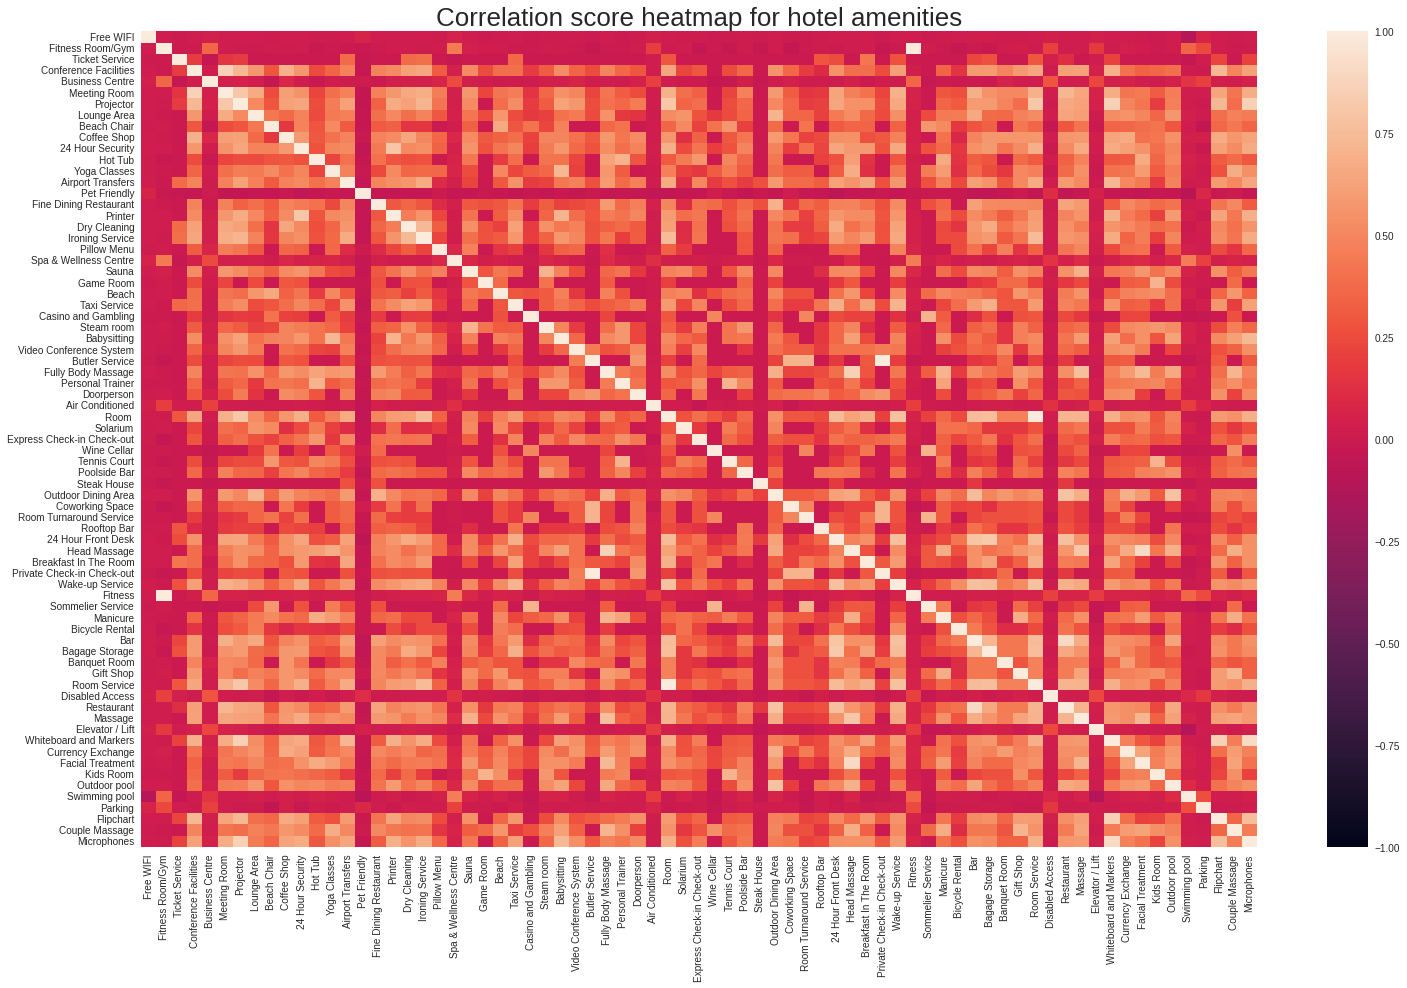

In [10]:
# preparing dataset to visualize amenities correlation heatmap and frequency heatmap
amenitiesToVisualize = amenitiesAll.drop(columns=["hotel_id"])
fig, ax = plt.subplots(figsize = (25,15))
sns.heatmap(amenitiesToVisualize.corr(), vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 26})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation score heatmap for hotel amenities", fontsize=26)


### <br> Concusions: 
#### - most of amenities are highly correlated for this set of data so will be skipped for clustering analysis
#### - this set of data is completely random and have different numbers of hotels for different regions so the picture above depends on  regions which is the most representative in the dataset
#### - more valuable will be to show correlations scores for different set of hotels from different regions/cities so this analysis will be repeated <br>


In [11]:
amenities_freq_mat = np.dot(amenitiesToVisualize.T, amenitiesToVisualize)
amenities_freq = pd.DataFrame(amenities_freq_mat, columns = amenitiesToVisualize.columns, index = amenitiesToVisualize.columns)

#### <br> Below is presented a frequency heatmap that was performed to understand what is the fequency of each of hotels' amenities in a given set of characteristics <br>


Text(0.5, 1.0, 'Frequency heatmap for hotel amenities')

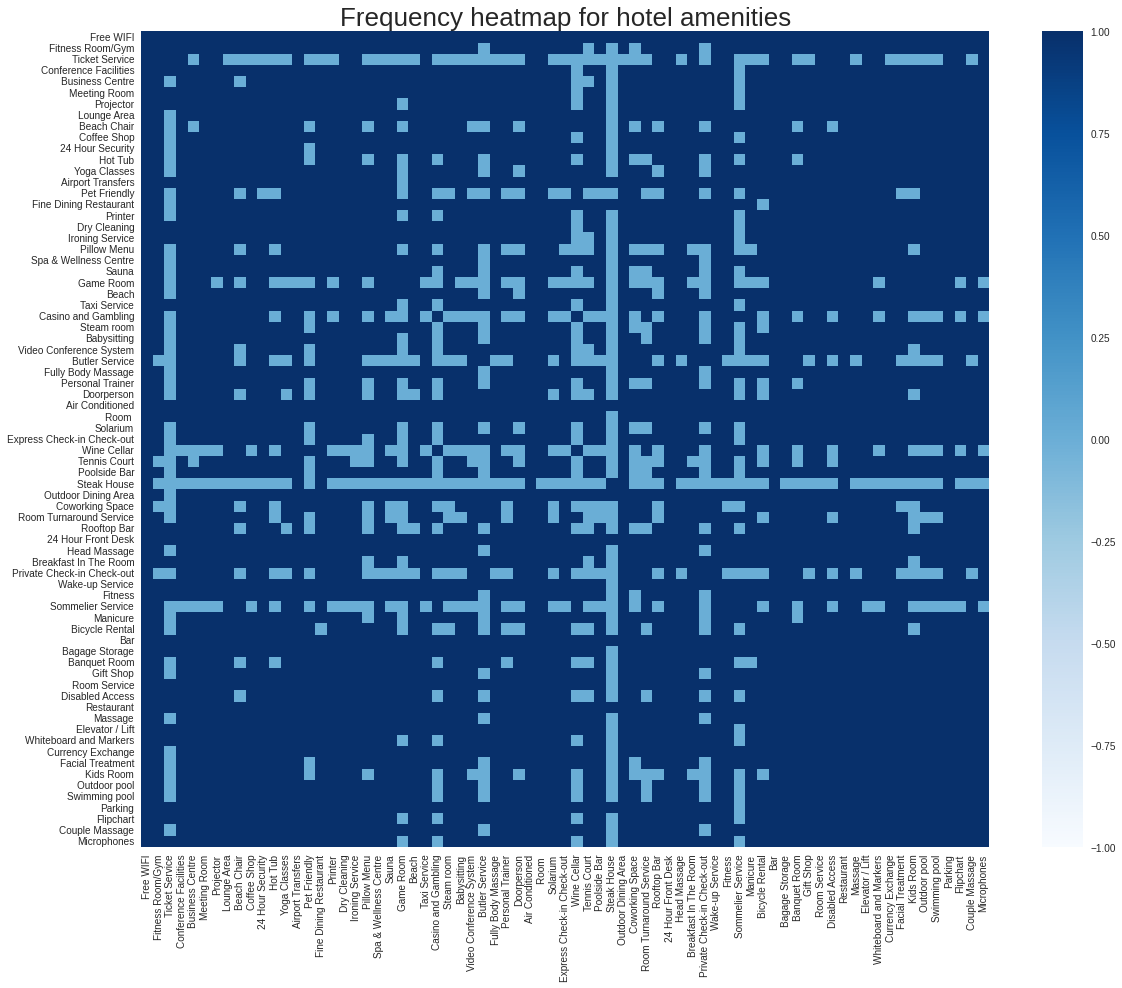

In [12]:
fig, ax = plt.subplots(figsize = (19,15))
sns.heatmap(amenities_freq, cmap = "Blues",vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 22})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Frequency heatmap for hotel amenities", fontsize=26)

### <br> Conclusions:
#### - most of amenities showed high frequency in a given dataset;
#### - regarding amenities with low frequency it is possible that the given set of data contained only a few hotels from the area where such amenities are typical;
#### - correlations scores of frequenscy should be shown for different set of hotels amenities for different regions/cities . <br>


### Creating final dataset for clustering analysis

In [13]:
fileWorking = fileWorking.merge(amenitiesAll, how="left", on="hotel_id")
fileWorking = fileWorking.drop(columns=["amenity"])
fileWorking.columns = fileWorking.columns.str.lower()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    2000 non-null   int64  
 1   hotel_city                  2000 non-null   int64  
 2   hotel_type                  2000 non-null   int64  
 3   hotel_country               1999 non-null   object 
 4   hotel_currency_code         2000 non-null   object 
 5   hotel_lat                   2000 non-null   float64
 6   hotel_lon                   2000 non-null   float64
 7   hotel_distance              2000 non-null   float64
 8   rooms_count                 2000 non-null   int64  
 9   label                       60 non-null     object 
 10  apartment                   2000 non-null   float64
 11  double                      2000 non-null   float64
 12  family                      2000 non-null   float64
 13  others                      2000 

## Data Cleaning

### Removing duplicates

In [14]:
filesWorkingCleaned = fileWorking.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

In [15]:
def mappingCategoricalData(seriesUnique):
    catData = {}
    for i, code in enumerate(seriesUnique):
        catData[code] = i+1
    return catData

#### handling information for hotel_currency_code

In [16]:
filesWorkingCleaned["hotel_currency_code"].isna().sum()

0

In [17]:
curr = filesWorkingCleaned["hotel_currency_code"].unique()
currCode = mappingCategoricalData(curr)
filesWorkingCleaned["hotel_currency_code"] = filesWorkingCleaned["hotel_currency_code"].map(currCode)

#### handling information for hotel_country

In [18]:
filesWorkingCleaned["hotel_country"].isna().sum()

1

In [19]:
co = filesWorkingCleaned["hotel_country"].unique()
country = mappingCategoricalData(co)
filesWorkingCleaned["hotel_country"] = filesWorkingCleaned["hotel_country"].map(country)

#### handling information for rooms_count

In [20]:
filesWorkingCleaned["rooms_count"].isna().sum()

0

#### handling information for label

In [21]:
filesWorkingCleaned["label"].value_counts(dropna=False)

NaN          1940
green_key      60
Name: label, dtype: int64

In [22]:
filesWorkingCleaned["green_key"] = [1 if x == "green_key" else 0 for x in filesWorkingCleaned["label"]]
filesWorkingCleaned = filesWorkingCleaned.drop(columns=["label"])

#### handling information for hotel_lat and hotel_lon

In [23]:
filesWorkingCleaned["hotel_lat"] = filesWorkingCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingCleaned["hotel_lon"] = filesWorkingCleaned["hotel_lon"].apply(lambda x: round(x,5))

In [24]:
filesWorkingCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    2000 non-null   int64  
 1   hotel_city                  2000 non-null   int64  
 2   hotel_type                  2000 non-null   int64  
 3   hotel_country               2000 non-null   int64  
 4   hotel_currency_code         2000 non-null   int64  
 5   hotel_lat                   2000 non-null   float64
 6   hotel_lon                   2000 non-null   float64
 7   hotel_distance              2000 non-null   float64
 8   rooms_count                 2000 non-null   int64  
 9   apartment                   2000 non-null   float64
 10  double                      2000 non-null   float64
 11  family                      2000 non-null   float64
 12  others                      2000 non-null   float64
 13  quadruple                   2000 

### Visualize heatmap for all hotel characteristics

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics')

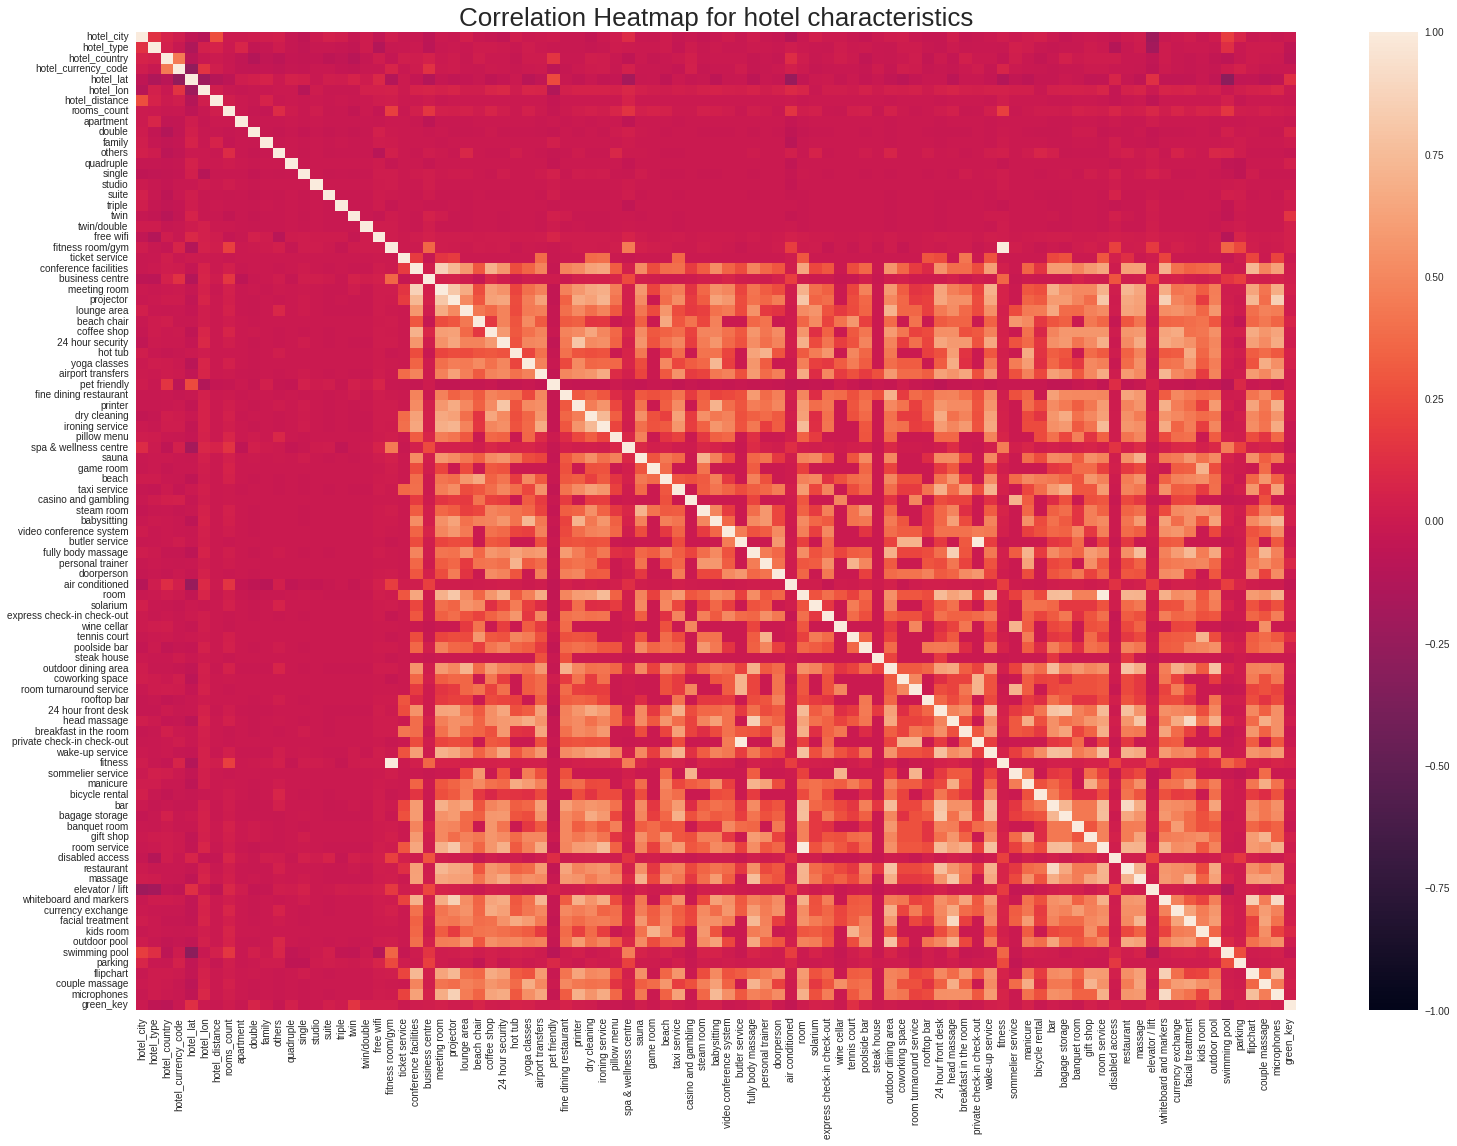

In [25]:
toPlot = filesWorkingCleaned.drop(columns=["hotel_id"])
plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(toPlot.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics", fontdict={"fontsize":26})

### <br> Conclusions:
#### - As it was written above lots of hotels amenities are highly correlated with one another;
#### - **Air conditioned**, **swimming pool**, **spa** etc are negatively correlated with hotel_lat so depending on the region their impact for the clustering analysis can differ;
#### - **Elevator/lift** is negatively correlated with city and hotel type, this corrlation it should be analysed among hotels within the same city;
#### - **Pet friendly** is negatively correlated with hotel_lon so in regions where there will be only few pet friendly hotels this amenity will be differentating the quality of the hotel. <br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was infinite. In the future was planned to add the treshold variable as the function parameters to define itself from how high of treshold characteristics should be removed.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [26]:
def calc_vif(df, col_names):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df[col_names]
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[vif["VIF"].isnull()]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

def reduce_dimensions_by_pca(df):
    # reduce dimentions if there are still a lot of variables
    pca = PCA(n_components=0.95)
    numpy_arr = pca.fit_transform(df)
    df_reduced = pd.DataFrame(data=numpy_arr.flatten())

    return df_reduced

In [27]:
toPlot.columns

Index(['hotel_city', 'hotel_type', 'hotel_country', 'hotel_currency_code',
       'hotel_lat', 'hotel_lon', 'hotel_distance', 'rooms_count', 'apartment',
       'double', 'family', 'others', 'quadruple', 'single', 'studio', 'suite',
       'triple', 'twin', 'twin/double', 'free wifi', 'fitness room/gym',
       'ticket service', 'conference facilities', 'business centre',
       'meeting room', 'projector', 'lounge area', 'beach chair',
       'coffee shop', '24 hour security', 'hot tub', 'yoga classes',
       'airport transfers', 'pet friendly', 'fine dining restaurant',
       'printer', 'dry cleaning', 'ironing service', 'pillow menu',
       'spa & wellness centre', 'sauna', 'game room', 'beach', 'taxi service',
       'casino and gambling', 'steam room', 'babysitting',
       'video conference system', 'butler service', 'fully body massage',
       'personal trainer', 'doorperson', 'air conditioned', 'room ',
       'solarium', 'express check-in check-out', 'wine cellar', 'tennis

In [28]:
toReduce = calc_vif(toPlot,['hotel_city', 'hotel_type', 'hotel_country', 'hotel_currency_code',
       'hotel_lat', 'hotel_lon', 'hotel_distance', 'rooms_count', 'apartment',
       'double', 'family', 'others', 'quadruple', 'single', 'studio', 'suite',
       'triple', 'twin', 'twin/double', 'room service', 'rooftop bar',
       'steak house', 'express check-in check-out', 'doorperson',
       'elevator / lift', 'bagage storage', 'couple massage', 'ticket service',
       'fine dining restaurant', 'airport transfers', 'room ',
       'casino and gambling', 'massage', 'free wifi', 'fully body massage',
       'pillow menu', 'outdoor dining area', 'room turnaround service',
       'pet friendly', 'wake-up service', 'whiteboard and markers',
       'beach chair', 'facial treatment', '24 hour security', 'flipchart',
       'beach', 'hot tub', 'private check-in check-out', 'taxi service',
       'fitness', 'bar', 'poolside bar', 'meeting room', 'dry cleaning',
       'solarium', 'parking', 'babysitting', 'video conference system',
       'sommelier service', 'currency exchange', 'sauna', 'projector',
       'head massage', 'wine cellar', 'breakfast in the room',
       'conference facilities', 'business centre', 'steam room',
       'yoga classes', '24 hour front desk', 'gift shop', 'restaurant',
       'swimming pool', 'air conditioned', 'outdoor pool', 'ironing service',
       'lounge area', 'fitness room/gym', 'coworking space', 'disabled access',
       'kids room', 'tennis court', 'spa & wellness centre', 'printer',
       'coffee shop', 'banquet room', 'butler service', 'personal trainer',
       'microphones', 'manicure', 'bicycle rental', 'game room', 'green_key'])

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### <br> Removing from the working file variables which are highly correlated <br>

In [29]:
filesWorkingReduced = select_variables(filesWorkingCleaned, toReduce)
filesWorkingReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               2000 non-null   int64  
 1   hotel_city             2000 non-null   int64  
 2   hotel_type             2000 non-null   int64  
 3   hotel_country          2000 non-null   int64  
 4   hotel_currency_code    2000 non-null   int64  
 5   hotel_lat              2000 non-null   float64
 6   hotel_lon              2000 non-null   float64
 7   hotel_distance         2000 non-null   float64
 8   rooms_count            2000 non-null   int64  
 9   apartment              2000 non-null   float64
 10  double                 2000 non-null   float64
 11  family                 2000 non-null   float64
 12  others                 2000 non-null   float64
 13  quadruple              2000 non-null   float64
 14  single                 2000 non-null   float64
 15  stud

In [30]:
filesWorkingAnalysis = filesWorkingReduced.drop(columns=["hotel_id"])

In [31]:
#### ploting correlation heatmap for final hotel characteristics

Text(0.5, 1.0, 'Correlation heatmap for characteristics with VIF score lower than infinite')

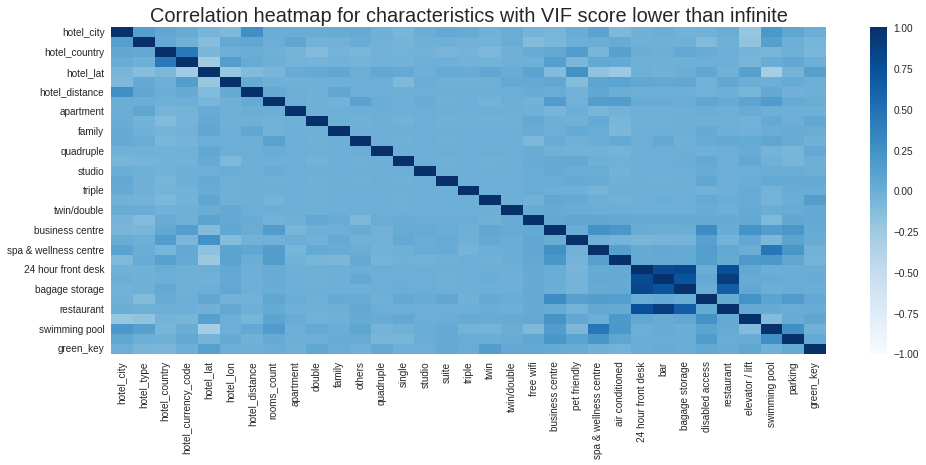

In [32]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(filesWorkingAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than infinite", fontsize=20)

### <br> Conclusions:
#### - function detecting multcolinearity was removing characteristics with infinitive VIF score, that is why there are still characteristics that are highly correlated like country and hotel_currency_code
#### - in future analysis there should be removed all correlated characteristics which VIF score was above 5 and see how manu of the will remain and how the clusters will look like. <br>


## Clustering analysis

### <br>There were performed two analysis:
#### 1. data that have not reduced dimentionality with PCA
#### 2. data with reduced dimentionality with PCA <br>

### 1. For all reduced characteristics

#### preparation data for scalling and scaling data

In [33]:
x = filesWorkingAnalysis
x.shape

(2000, 33)

In [34]:
x_scaled = preprocessing.scale(x)

#### <br> To choose the best number of clusters I generated a **silhouette score** for a range of clusters
#### The typical method for finding the proper number of clusers is Elbow method but to cluster numbers greater that 100 the calculation of the data is very slow
#### The silhouette score is generally used to verify if the number of clusters predicted by Elbow method is the best that is why I generated it for the  set of clusters and chosed the best one among of them  <br>

In [35]:
scores = {}
for i in range(700,1500,50):
    km = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    y_means = km.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, km.labels_, metric="euclidean")
    scores[i] = score


#### <br> Visualizing silhouette scores for a given set of cluster numbers <br> 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


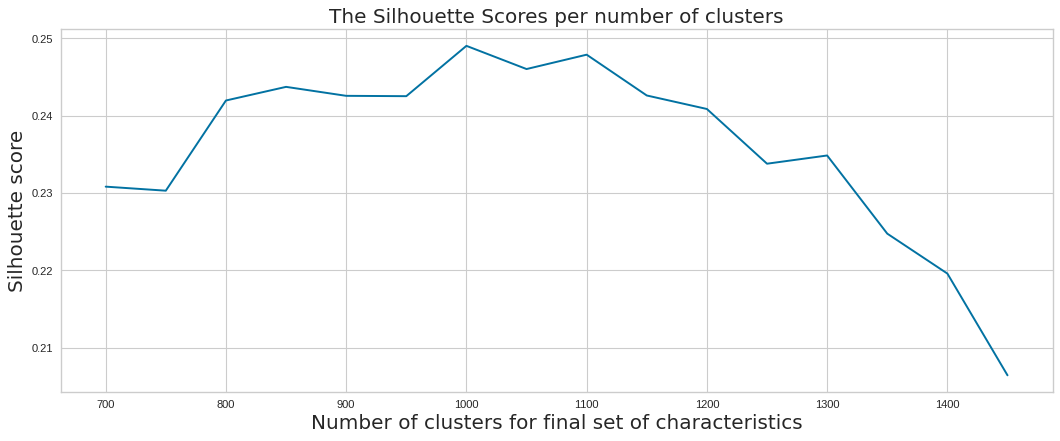

In [36]:
lists = sorted(scores.items())
x,y = zip(*lists)

plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.plot(x,y)
plt.title("The Silhouette Scores per number of clusters", **axis_font)
plt.xlabel("Number of clusters for final set of characteristics",**axis_font)
plt.ylabel("Silhouette score",**axis_font)
plt.show()


### <br> Conclusion: 
#### as it is visible in the chart above the highest Silhouette Score in that analysis was for 1000 <br>

In [37]:
highest = 700
for k,v in scores.items():
    if v > scores[highest]:
        highest = k        

#### <br> Calculating KMeans for a given number of clusters <br>

In [38]:
km = KMeans(n_clusters = highest, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x_scaled)

#### <br> Adding found cluster numbers to dataframe <br>

In [39]:
y_means = pd.DataFrame(y_means)
workingFileClusters = pd.concat([filesWorkingReduced, y_means], axis = 1)
workingFileClusters = workingFileClusters.rename(columns = {0: "Clusters"})
workingFileClusters.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,apartment,...,24 hour front desk,bar,bagage storage,disabled access,restaurant,elevator / lift,swimming pool,parking,green_key,Clusters
0,1,22886,8,1,1,0.09102,32.47620,4.67,23,0.0,...,0,0,0,0,0,1,0,1,0,944
1,66,12,15,2,2,56.18580,-4.50023,7.25,1,0.0,...,0,0,0,0,0,0,1,1,0,236
2,68,15,4,3,3,24.46660,54.36660,1.16,84,0.0,...,0,0,0,0,0,0,1,1,0,517
3,73,15,5,3,3,24.49917,54.38133,2.76,248,0.0,...,0,0,0,1,0,1,1,1,1,403
4,168,22,4,4,4,30.40320,-9.59950,1.28,328,0.0,...,0,0,0,0,0,1,1,1,0,155


### 2. Reducing dimentions with PCA and applying the KMeans anaysis for such data

In [40]:
filesWorkingReduced1 = filesWorkingReduced.set_index("hotel_id")
x2 = reduce_dimensions_by_pca(filesWorkingReduced1)

#### <br> Applying the Elbow Method to find the best number of clusters<br>

In [41]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x2)
    wcss.append(kmeans.inertia_)

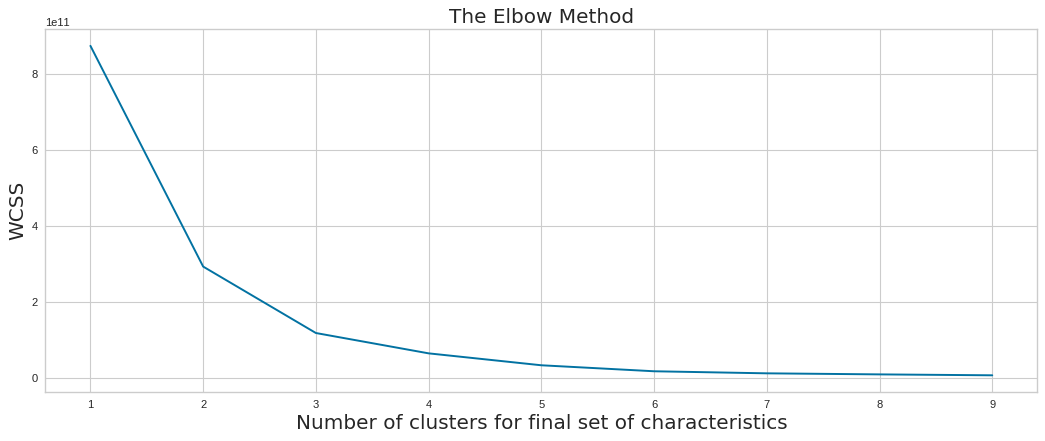

In [42]:
plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.plot(range(1,10),wcss)
plt.title("The Elbow Method", **axis_font)
plt.xlabel("Number of clusters for final set of characteristics",**axis_font)
plt.ylabel("WCSS",**axis_font)
plt.show()

### <br> Calculating a silhouette scores for set of cluster numbers <br>

In [43]:
scores2 = {}
for i in range(2,25):
    km = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    y_means = km.fit_predict(x2)
    score = silhouette_score(x2, km.labels_, metric="euclidean")
    scores2[i] = score

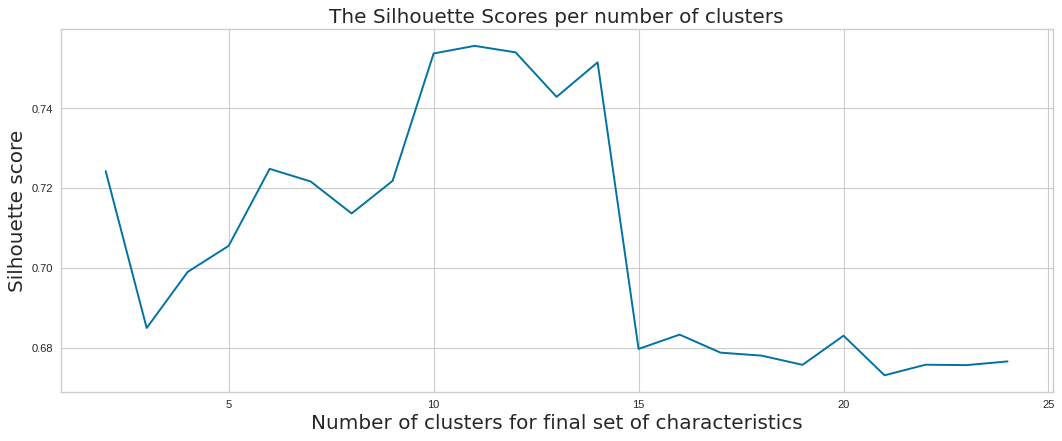

In [44]:
lists = sorted(scores2.items())
x,y = zip(*lists)

plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.plot(x,y)
plt.title("The Silhouette Scores per number of clusters", **axis_font)
plt.xlabel("Number of clusters for final set of characteristics",**axis_font)
plt.ylabel("Silhouette score",**axis_font)
plt.show()

In [45]:
highest2 = 2
for k,v in scores2.items():
    if v > scores2[highest2]:
        highest2 = k     

In [46]:
km = KMeans(n_clusters = highest2, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_means2 = km.fit_predict(x2)

#### <br> Calculating the silhouette score to check if the number is matched correctly <br>

In [47]:
score = silhouette_score(x2, km.labels_, metric="euclidean")
score

0.75566989023685

### Adding found cluster numbers to dataframe

In [48]:
y_means2 = pd.DataFrame(y_means2)
workingFileClusters = pd.concat([workingFileClusters, y_means2], axis = 1)
workingFileClusters = workingFileClusters.rename(columns = {0: "Clusters2"})
workingFileClusters.head(125)

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,apartment,...,bar,bagage storage,disabled access,restaurant,elevator / lift,swimming pool,parking,green_key,Clusters,Clusters2
0,1,22886,8,1,1,0.09102,32.47620,4.67,23,0.0,...,0,0,0,0,1,0,1,0,944,10
1,66,12,15,2,2,56.18580,-4.50023,7.25,1,0.0,...,0,0,0,0,0,1,1,0,236,7
2,68,15,4,3,3,24.46660,54.36660,1.16,84,0.0,...,0,0,0,0,0,1,1,0,517,7
3,73,15,5,3,3,24.49917,54.38133,2.76,248,0.0,...,0,0,1,0,1,1,1,1,403,7
4,168,22,4,4,4,30.40320,-9.59950,1.28,328,0.0,...,0,0,0,0,1,1,1,0,155,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,4695,913,3,2,2,53.72332,-0.40975,5.57,116,0.0,...,0,0,1,0,1,1,1,0,776,7
121,4783,940,25,25,4,41.00883,28.97530,0.42,60,0.0,...,0,0,0,0,1,0,0,0,234,7
122,4857,950,3,26,19,26.91775,75.81161,1.74,32,0.0,...,1,1,0,1,1,0,1,0,389,7
123,4927,961,3,27,6,31.75444,35.19240,2.54,35,0.0,...,0,0,0,0,0,0,1,0,580,7


### <br>Checking results of two performed cluster analysis for the most known differentiationg characteristics i the dataset: city and hotel type<br>

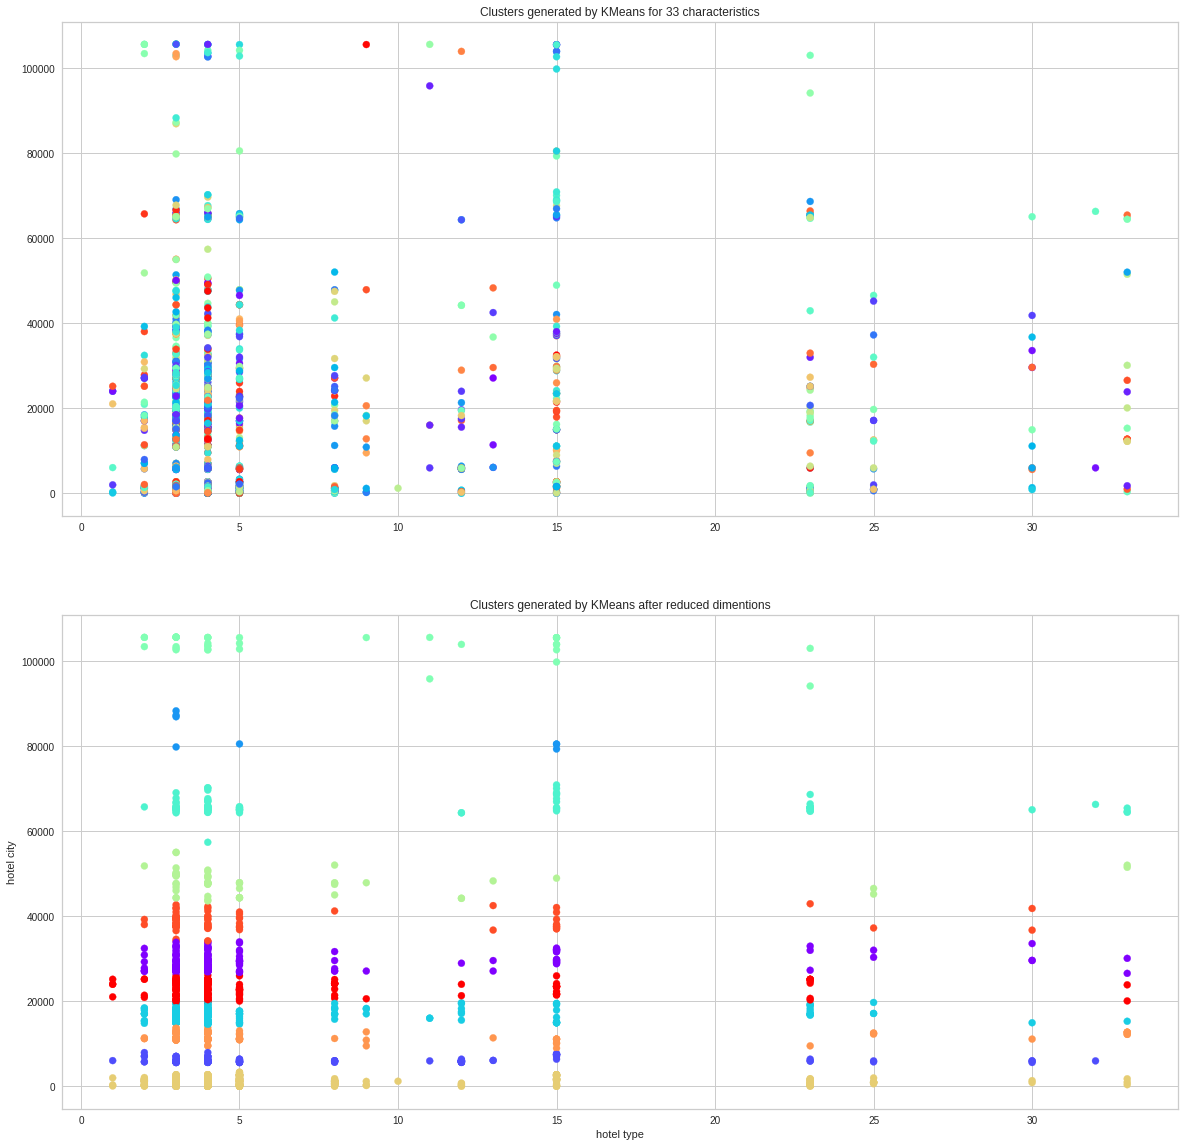

In [49]:

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,20))
axis_font = {'fontname':'Arial', 'size':'18'}
ax1.scatter(workingFileClusters["hotel_type"], workingFileClusters["hotel_city"], c=workingFileClusters["Clusters"], cmap="rainbow")
ax1.set_title('Clusters generated by KMeans for 33 characteristics')

ax2.scatter(workingFileClusters["hotel_type"], workingFileClusters["hotel_city"], c=workingFileClusters["Clusters2"], cmap="rainbow")
ax2.set(xlabel='hotel type', ylabel='hotel city',
       title='Clusters generated by KMeans after reduced dimentions')

plt.show()

## <br> Concusions:<br>
#### 1. Both performed cluster analysis shown the edge cases: first one with high number of clusters around - 1000 and the second one with the very low number - 11.
#### 2. Silhouette scores were also highly different for both analysis: for the first one was ~0.24 which is very low and is probably a reason of too many dimentions and finding proper clusters is more dificult. The second analysis had very high  Silhouette score ~0,75 but the number of was too low.
#### 3. As it shown for the charts above cluster analysis for whole set of characteristcs generated in some part different clusters for pair city-hotel type but only further analysis would show if it is correct, but the second approach showed that the city was the feature that played the most important role  in cluster creation for this pair of characteristics
#### 4. As it was visible for the second analysis the Elbow method is not a good cluster definer for such spread data. Generating the Silhouette scores seems to be better but needs to be checked if the highest Silhouette score gives the best prediction regarding number of clusters.
#### 5. This analysis should be repeated for data sets not only for particular city but with eaqual number of hotels from different hote types to have a better understanding of influence of the different characteristics per clustering but also with having more strict rule to removing collinear data - VIF score greater that 5 what is recomended 
#### 6. We do not know many clusters there should be and it needed to be calculated depending on data and characteristics that will be provided that is why  the same set of data should be also analysed with another clustering algorithm that do not need the number of clusters to be defined at the very beginning. The analysis from the point 5 will be performed using DBSCAN algorythm. <br>